# Transfer learning and fine-tuning

In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

1. Fine-Tuning: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Data preprocessing

### Data download

In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a `tf.data.Dataset` for training and validation using the `tf.keras.utils.image_dataset_from_directory` utility. You can learn more about loading images in this [tutorial](https://www.tensorflow.org/tutorials/load_data/images).

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_extracted", "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

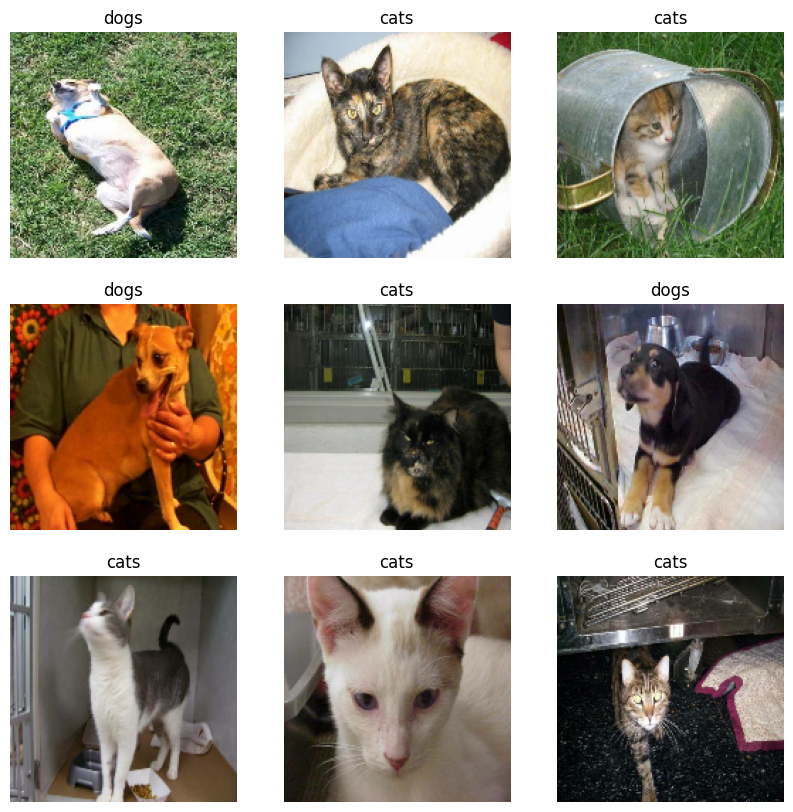

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `Model.fit`. They are inactive when the model is used in inference mode in `Model.evaluate`, `Model.predict`, or `Model.call`.

Let's repeatedly apply these layers to the same image and see the result.

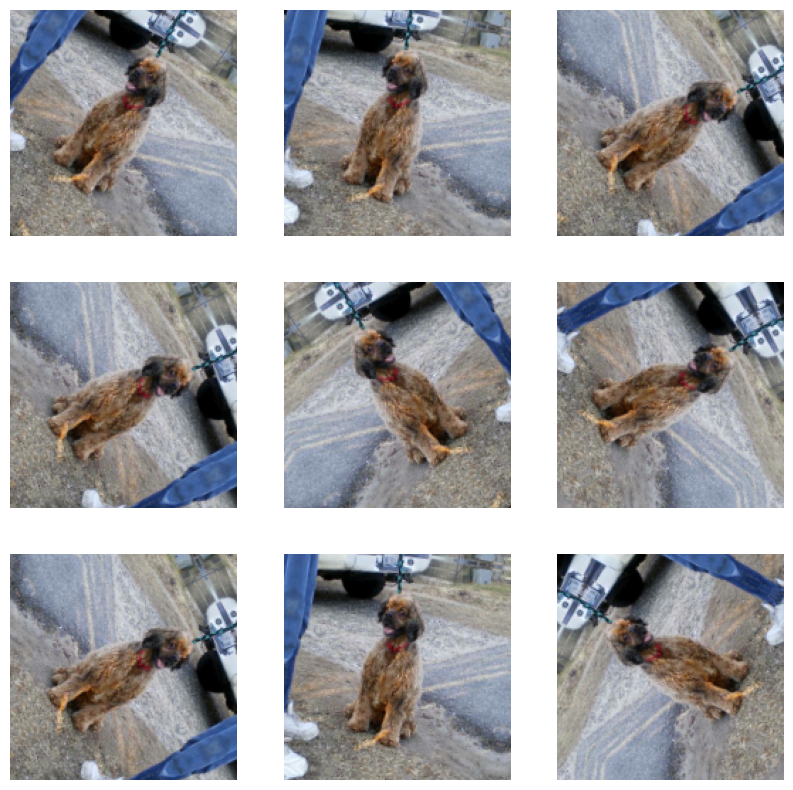

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [11]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

## Original MobileNet V2 Model

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [14]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [17]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

The 8+ million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [20]:
len(model.trainable_variables)

2

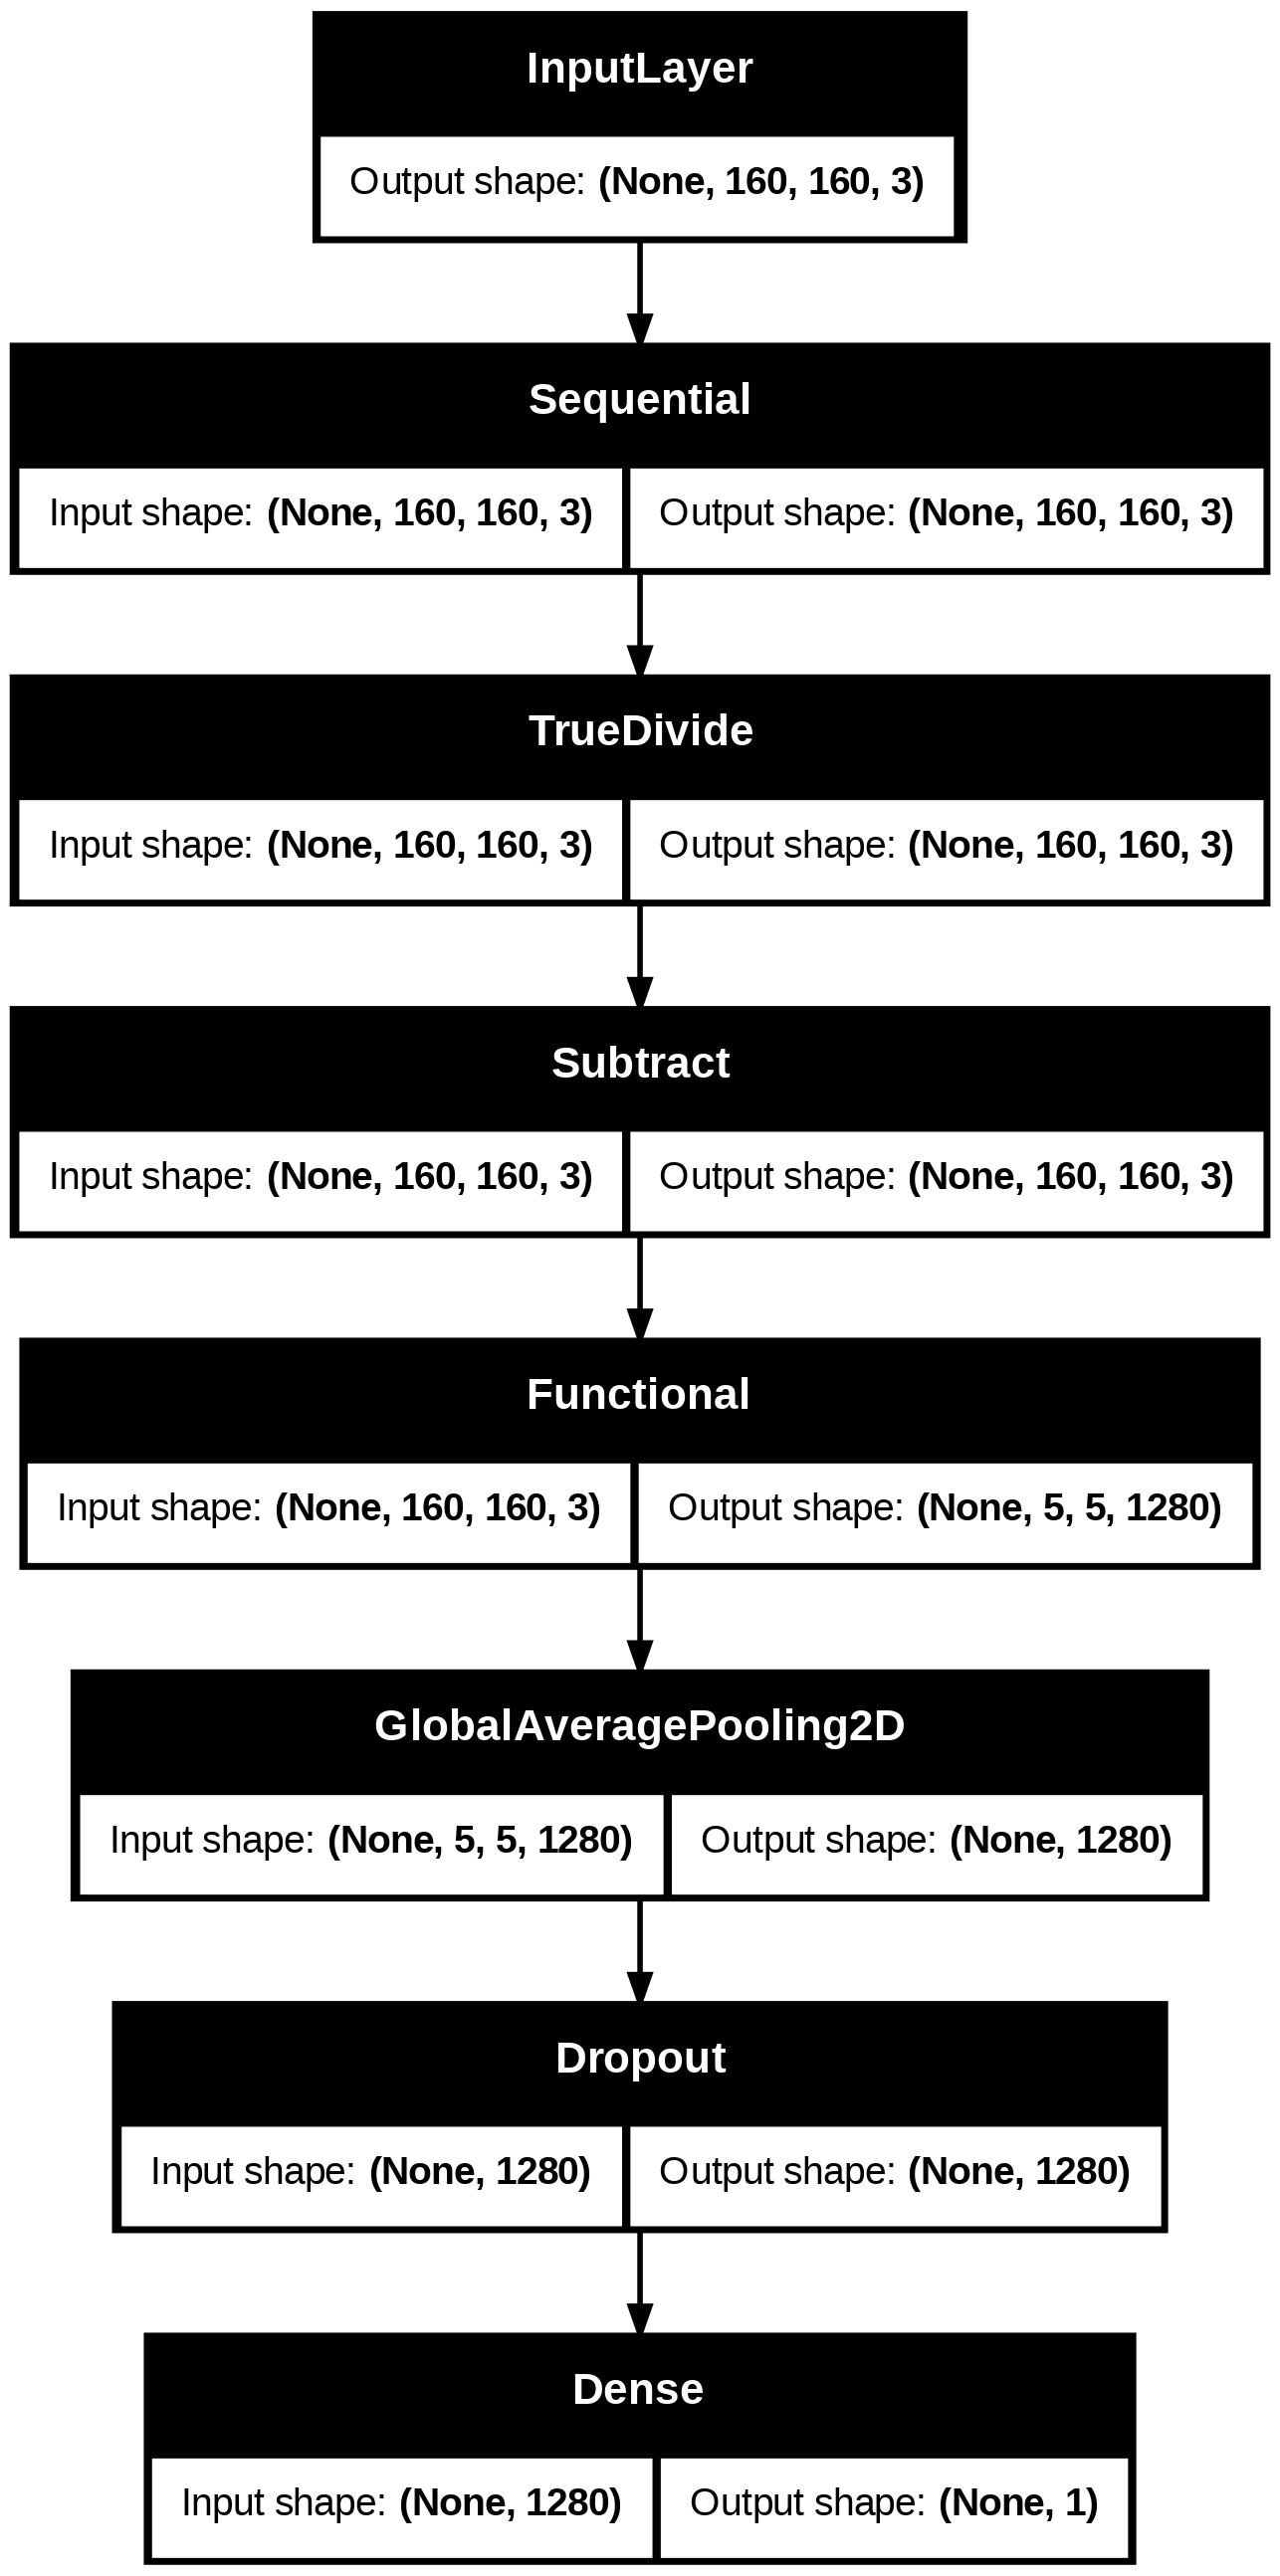

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile the model

Compile the model before training it. Since there are two classes and a sigmoid oputput, use the `BinaryAccuracy`.

In [22]:
base_learning_rate = 0.0001

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.3830 - loss: 0.9619


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.94
initial accuracy: 0.38


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.4631 - loss: 0.8629 - val_accuracy: 0.6300 - val_loss: 0.6275
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6523 - loss: 0.6302 - val_accuracy: 0.8243 - val_loss: 0.4548
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.7606 - loss: 0.4990 - val_accuracy: 0.9059 - val_loss: 0.3424
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8415 - loss: 0.3877 - val_accuracy: 0.9319 - val_loss: 0.2745
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.8690 - loss: 0.3468 - val_accuracy: 0.9493 - val_loss: 0.2235
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8858 - loss: 0.3087 - val_accuracy: 0.9616 - val_loss: 0.2008
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9102 - loss: 0.2691 - val_accuracy: 0.9641 - val_loss: 0.1784
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.9019 - loss: 0.2634 - val_accuracy: 0.9740 - v

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

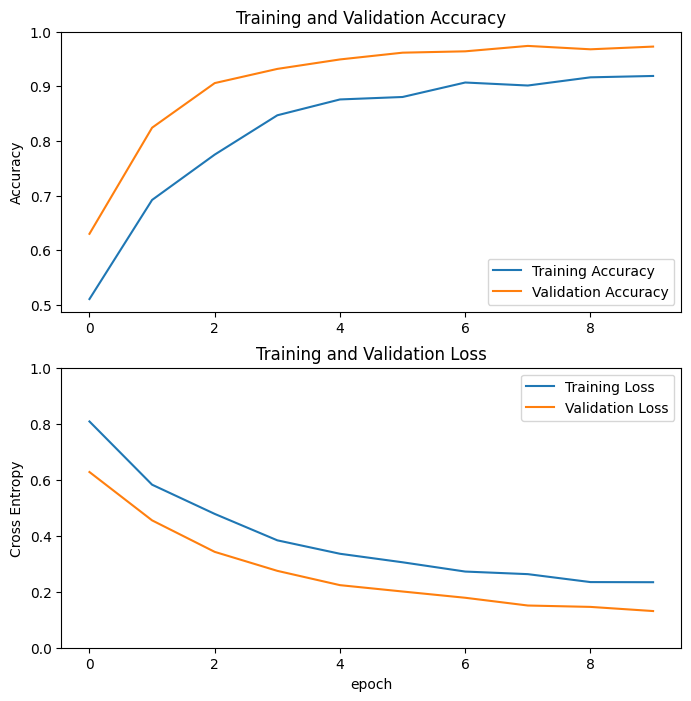

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the original base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the original base model:  154


### Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [32]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=len(history.epoch), validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.7967 - loss: 0.4096 - val_accuracy: 0.9777 - val_loss: 0.0937
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8941 - loss: 0.2710 - val_accuracy: 0.9814 - val_loss: 0.0739
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9118 - loss: 0.2132 - val_accuracy: 0.9827 - val_loss: 0.0636
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9241 - loss: 0.1969 - val_accuracy: 0.9851 - val_loss: 0.0568
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9312 - loss: 0.1709 - val_accuracy: 0.9889 - val_loss: 0.0485
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9417 - loss: 0.1411 - val_accuracy: 0.9851 - val_loss: 0.0477
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9388 - loss: 0.1550 - val_accuracy: 0.9827 - val_loss: 0.0439
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9420 - loss: 0.1334 - val_accuracy: 

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.


After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

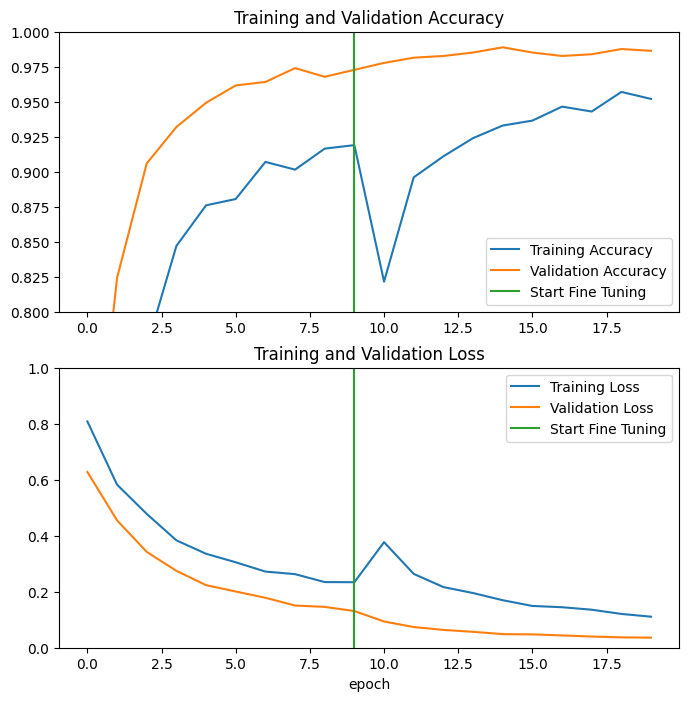

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy for original model :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9868 - loss: 0.0401
Test accuracy for original model : 0.9895833134651184


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1]
Labels:
 [0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1]


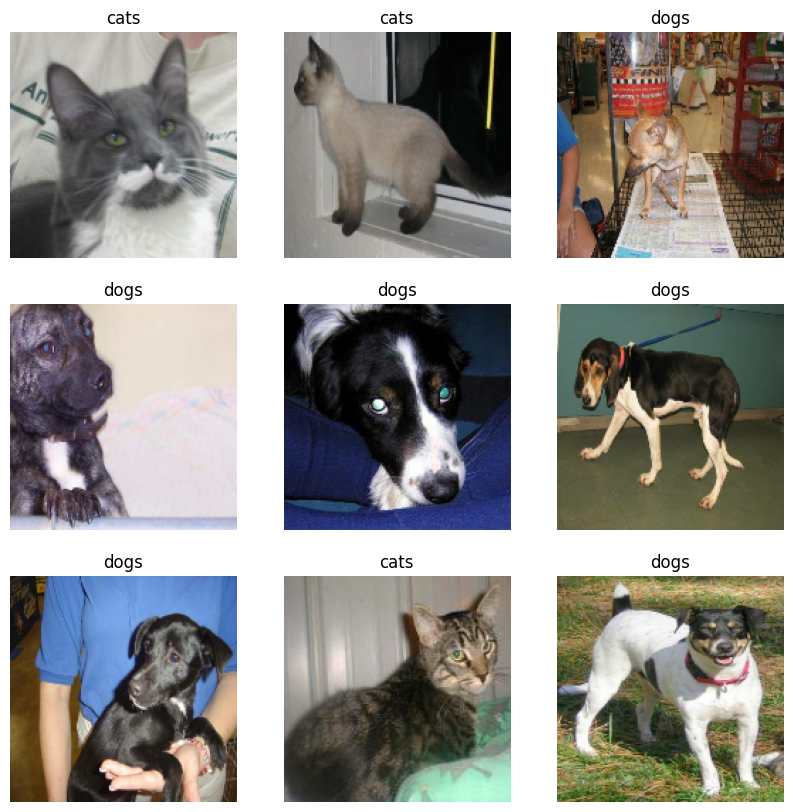

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## ResNet 101 Model

In [38]:
tf.keras.backend.clear_session()

In [39]:
base_model_resnet101 = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Feature Extraction

In [40]:
base_model_resnet101.trainable = False

In [41]:
base_model_resnet101.summary()

Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,658,176 (162.73 MB)

#### Add Classification Head

In [42]:
global_average_layer_resnet101 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_resnet101 = global_average_layer_resnet101(feature_batch)

In [43]:
prediction_layer_resnet101 = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch_resnet101 = prediction_layer(feature_batch_average_resnet101)

In [44]:
inputs_resnet101 = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs_resnet101)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model_resnet101(x, training=False)
x = global_average_layer_resnet101(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs_resnet101 = prediction_layer_resnet101(x)
model_resnet101 = tf.keras.Model(inputs_resnet101, outputs_resnet101)

In [45]:
model_resnet101.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 160, 160,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 160, 160)  │          0 │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 160, 160)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 160, 160)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 160, 160,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 160,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet101           │ (None, 5, 5,      │ 42,658,176 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet101[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,660,225 (162.74 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [46]:
len(model_resnet101.trainable_variables)

2

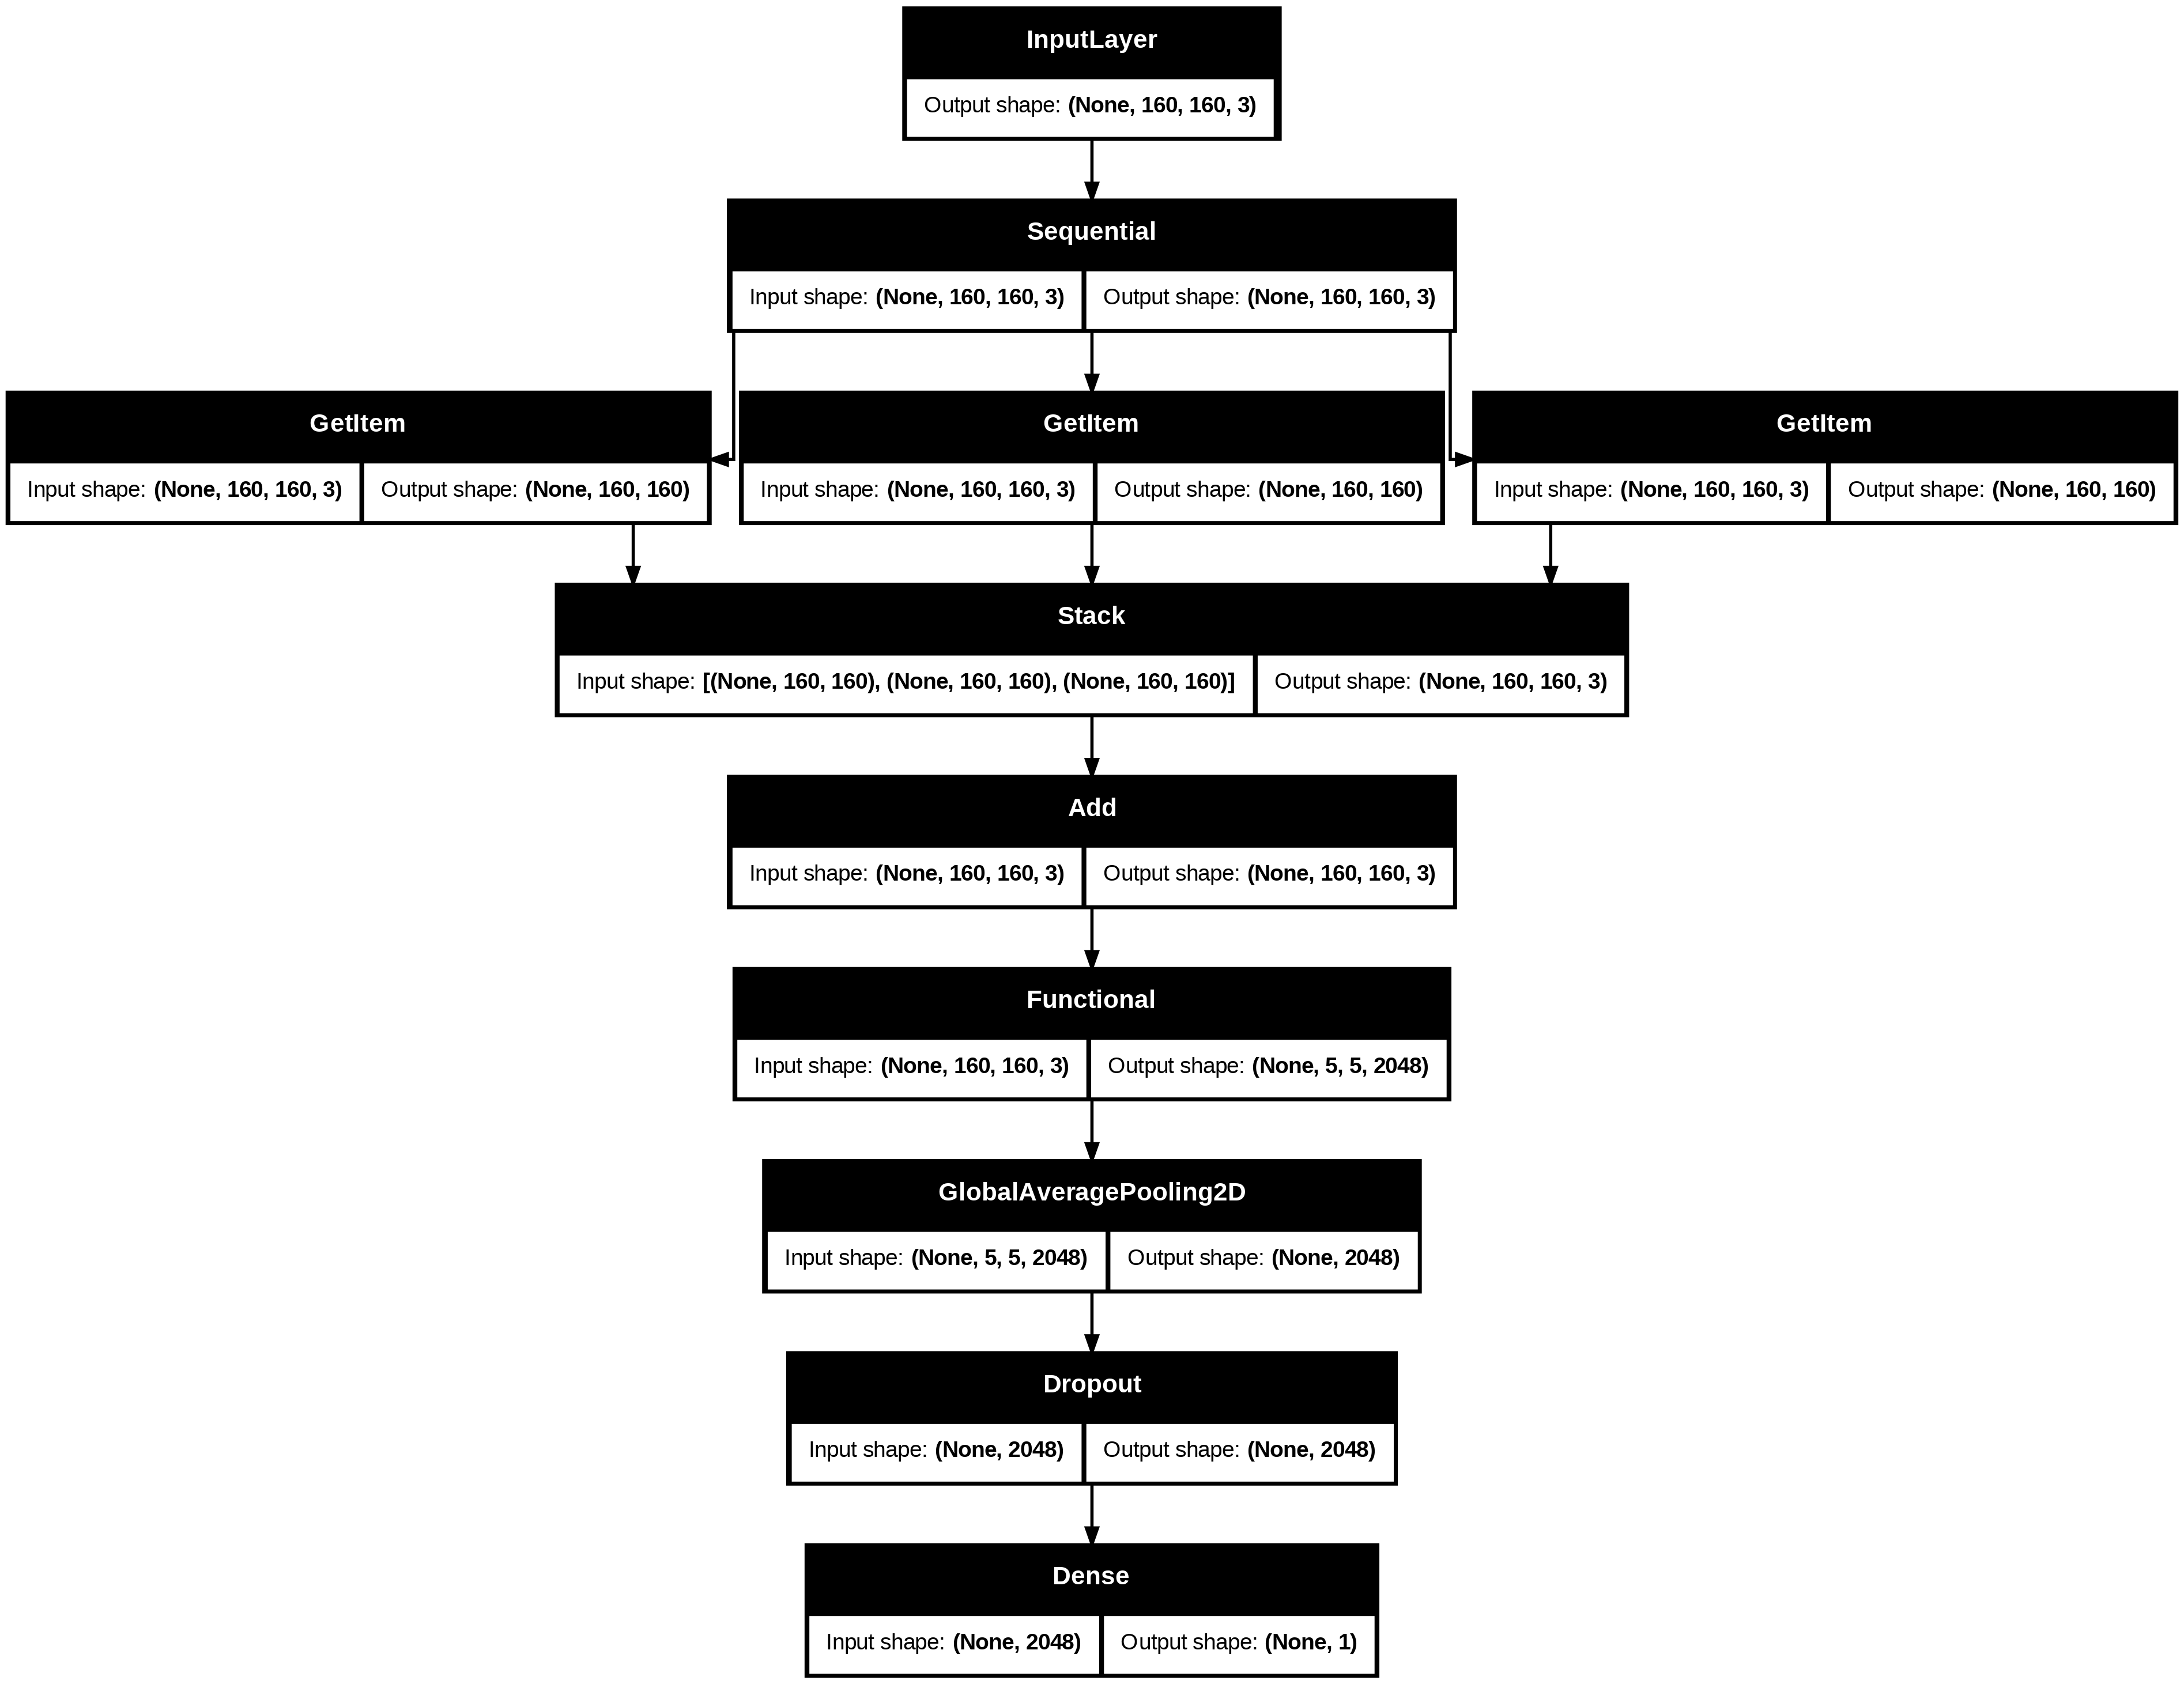

In [47]:
tf.keras.utils.plot_model(model_resnet101, show_shapes=True)

#### Compile the Model

In [48]:
model_resnet101.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

#### Train the model

In [49]:
loss0_resnet101, accuracy0_resnet101 = model_resnet101.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.3272 - loss: 1.5794


In [50]:
print("initial loss: {:.2f}".format(loss0_resnet101))
print("initial accuracy: {:.2f}".format(accuracy0_resnet101))

initial loss: 1.53
initial accuracy: 0.34


In [51]:
history_resnet101 = model_resnet101.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - accuracy: 0.4009 - loss: 1.3023 - val_accuracy: 0.6559 - val_loss: 0.6780
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.6484 - loss: 0.6807 - val_accuracy: 0.8490 - val_loss: 0.3627
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.8092 - loss: 0.4417 - val_accuracy: 0.9295 - val_loss: 0.2381
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.8664 - loss: 0.3311 - val_accuracy: 0.9493 - val_loss: 0.1762
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.8856 - loss: 0.2688 - val_accuracy: 0.9530 - val_loss: 0.1483
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.9126 - loss: 0.2314 - val_accuracy: 0.9641 - val_loss: 0.1205
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.9160 - loss: 0.2005 - val_accuracy: 0.9678 - val_loss: 0.1089
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - accuracy: 0.9251 - loss: 0.2008 - val_accu

#### Learning Curves

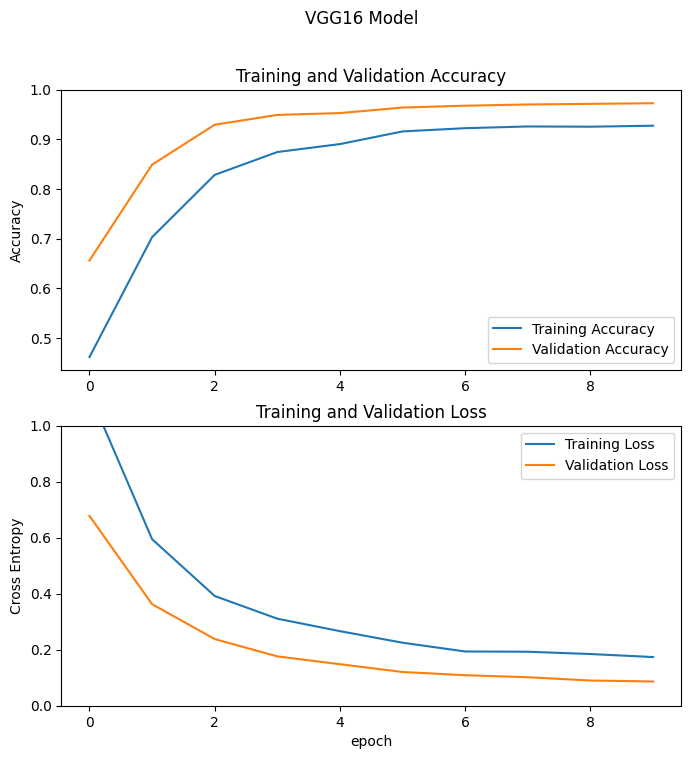

In [52]:
acc_resnet101 = history_resnet101.history['accuracy']
val_acc_resnet101 = history_resnet101.history['val_accuracy']

loss_resnet101 = history_resnet101.history['loss']
val_loss_resnet101 = history_resnet101.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_resnet101, label='Training Accuracy')
plt.plot(val_acc_resnet101, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_resnet101, label='Training Loss')
plt.plot(val_loss_resnet101, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.suptitle("VGG16 Model")
plt.show()

### Fine Tuning

#### Unfreeze the top layers of the model

In [53]:
base_model_resnet101.trainable = True

In [54]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the ResNet101 base model: ", len(base_model_resnet101.layers))

# Fine-tune from this layer onwards
fine_tune_at_resnet101 = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_resnet101.layers[:fine_tune_at_resnet101]:
  layer.trainable = False

Number of layers in the ResNet101 base model:  345


#### Compile the model

In [55]:
model_resnet101.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [56]:
model_resnet101.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 160, 160,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 160, 160)  │          0 │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 160, 160)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 160, 160)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 160, 160,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 160,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet101           │ (None, 5, 5,      │ 42,658,176 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet101[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,660,225 (162.74 MB)

 Trainable params: 21,692,417 (82.75 MB)

 Non-trainable params: 20,967,808 (79.99 MB)

#### Continue Training the model

In [57]:
history_fine_resnet101 = model_resnet101.fit(train_dataset, epochs=total_epochs, initial_epoch=len(history.epoch), validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 338ms/step - accuracy: 0.8979 - loss: 0.2695 - val_accuracy: 0.9827 - val_loss: 0.0507
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.9374 - loss: 0.1534 - val_accuracy: 0.9827 - val_loss: 0.0540
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 261ms/step - accuracy: 0.9504 - loss: 0.1193 - val_accuracy: 0.9827 - val_loss: 0.0533
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.9616 - loss: 0.0993 - val_accuracy: 0.9790 - val_loss: 0.0535
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.9636 - loss: 0.0922 - val_accuracy: 0.9814 - val_loss: 0.0483
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.9795 - loss: 0.0702 - val_accuracy: 0.9839 - val_loss: 0.0482
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - accuracy: 0.9886 - loss: 0.0495 - val_accuracy: 0.9814 - val_loss: 0.0476
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.9790 - loss: 0.0579 - 

In [58]:
acc_resnet101 += history_fine_resnet101.history['accuracy']
val_acc_resnet101 += history_fine_resnet101.history['val_accuracy']

loss_resnet101 += history_fine_resnet101.history['loss']
val_loss_resnet101 += history_fine_resnet101.history['val_loss']

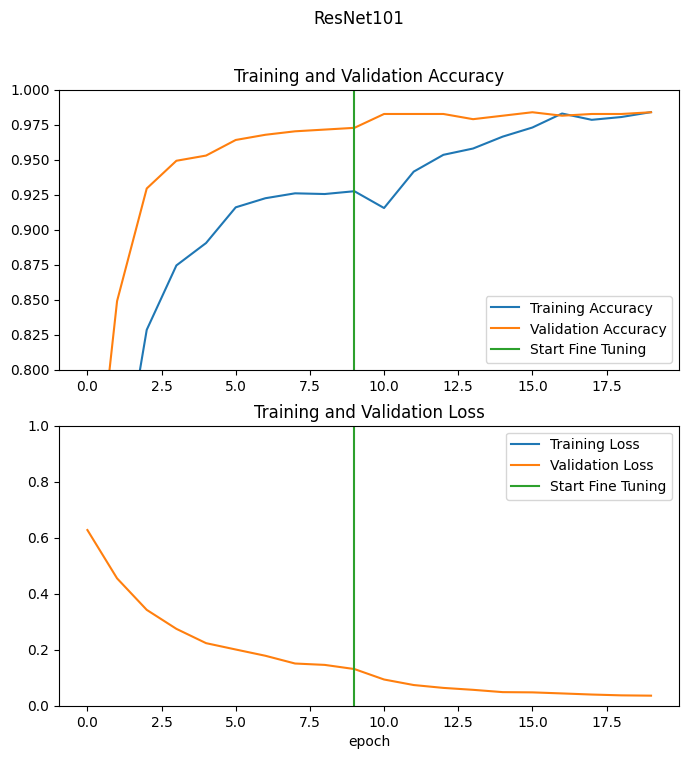

In [59]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_resnet101, label='Training Accuracy')
plt.plot(val_acc_resnet101, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.suptitle("ResNet101")
plt.show()

#### Evaluation and prediction

In [85]:
loss_resnet101, accuracy_resnet101 = model_resnet101.evaluate(test_dataset)
print('Test accuracy for ResNet101 model :', accuracy_resnet101)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9917 - loss: 0.0456
Test accuracy for ResNet101 model : 0.984375


## ResNet152 Model

In [61]:
tf.keras.backend.clear_session()

In [62]:
base_model_resnet152 = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Feature Extraction

In [63]:
base_model_resnet152.trainable = False

In [64]:
base_model_resnet152.summary()

Model: "resnet152"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 166, 166,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 80, 80,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 80, 80,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 80, 80,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 82, 82,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 40, 40,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 40, 40,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 40, 40,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 40, 40,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 40, 40,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 40, 40,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 40, 40,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 40, 40,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 40, 40,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 40, 40,    │      1,024 │ conv2_block1_3_c

 Total params: 58,370,944 (222.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,370,944 (222.67 MB)

#### Add Classification Head

In [65]:
global_average_layer_resnet152 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average_resnet152 = global_average_layer_resnet152(feature_batch)

In [66]:
prediction_layer_resnet152 = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch_resnet152 = prediction_layer(feature_batch_average_resnet152)

In [67]:
inputs_resnet152 = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs_resnet152)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model_resnet152(x, training=False)
x = global_average_layer_resnet152(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs_resnet152 = prediction_layer_resnet152(x)
model_resnet152 = tf.keras.Model(inputs_resnet152, outputs_resnet152)

In [68]:
model_resnet152.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 160, 160,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 160, 160)  │          0 │ sequential[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 160, 160)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 160, 160)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 160, 160,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 160,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152           │ (None, 5, 5,      │ 58,370,944 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet152[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,372,993 (222.68 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [69]:
len(model_resnet152.trainable_variables)

2

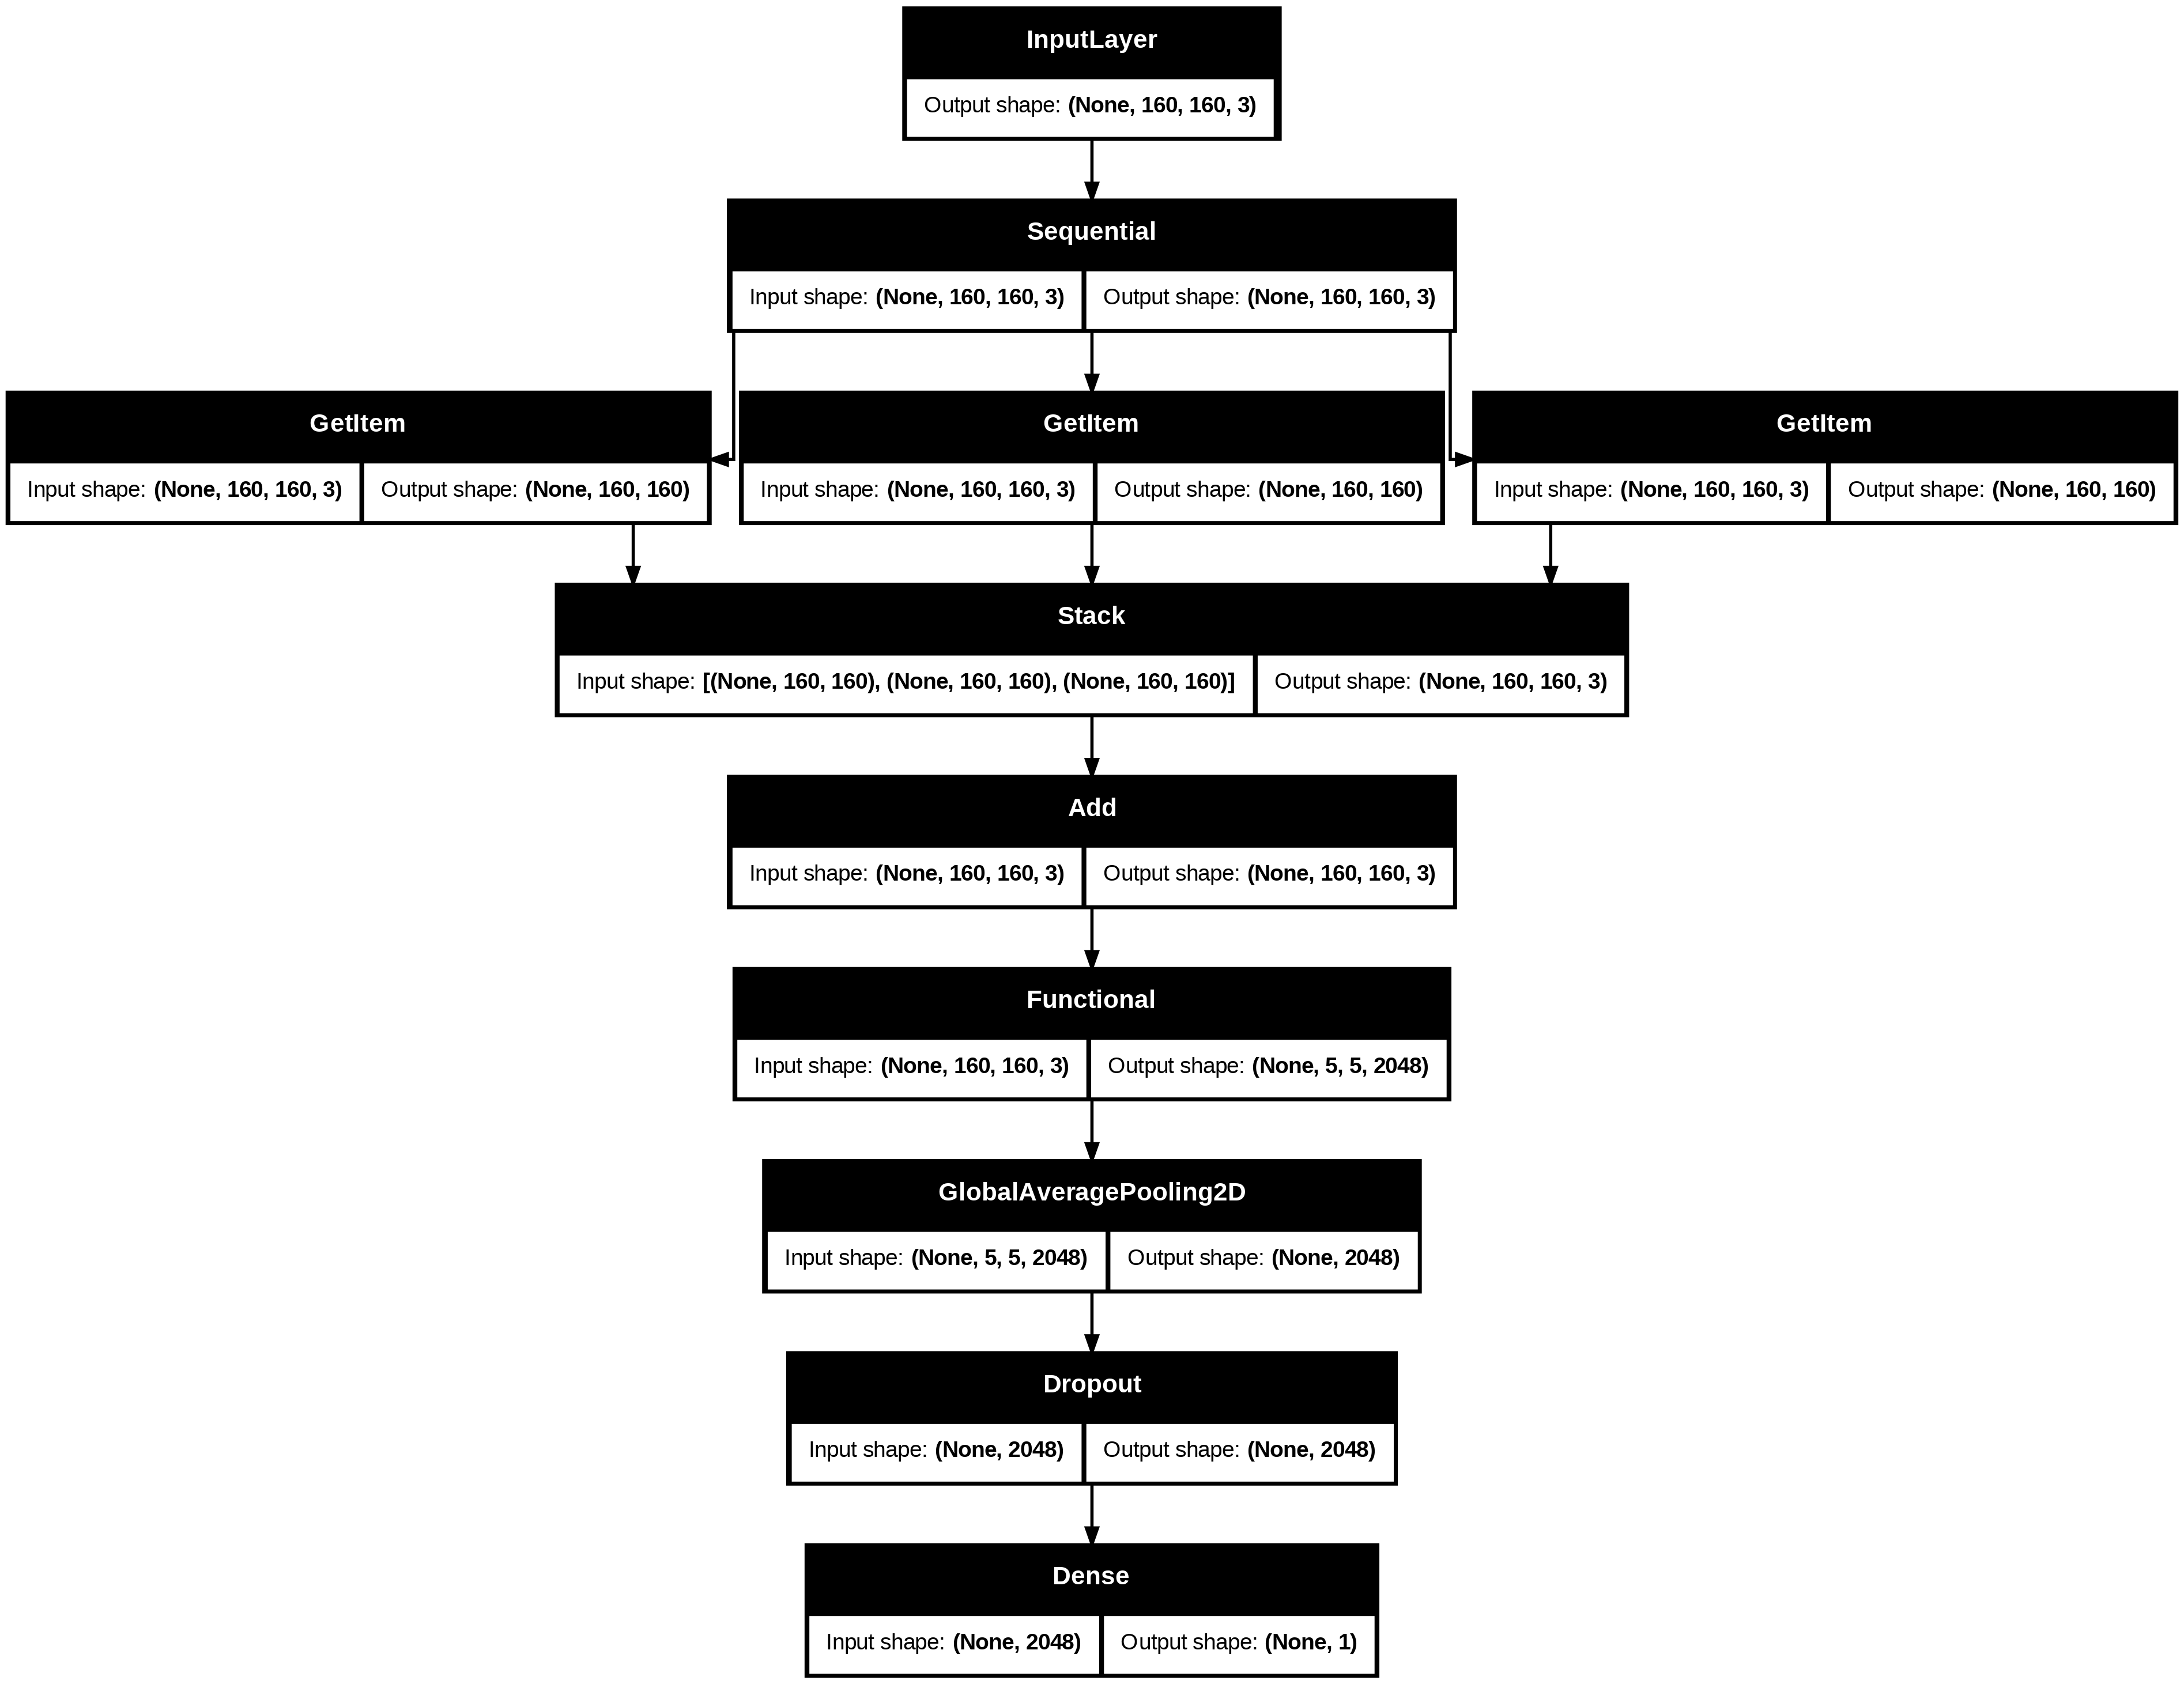

In [70]:
tf.keras.utils.plot_model(model_resnet152, show_shapes=True)

#### Compile the Model

In [71]:
model_resnet152.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

#### Train the model

In [72]:
loss0_resnet152, accuracy0_resnet152 = model_resnet152.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.5083 - loss: 0.8230


In [73]:
print("initial loss: {:.2f}".format(loss0_resnet152))
print("initial accuracy: {:.2f}".format(accuracy0_resnet152))

initial loss: 0.82
initial accuracy: 0.53


In [74]:
history_resnet152 = model_resnet152.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 250ms/step - accuracy: 0.5907 - loss: 0.7817 - val_accuracy: 0.8651 - val_loss: 0.3592
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.7912 - loss: 0.4610 - val_accuracy: 0.9307 - val_loss: 0.2194
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.8432 - loss: 0.3577 - val_accuracy: 0.9468 - val_loss: 0.1644
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.8779 - loss: 0.2944 - val_accuracy: 0.9530 - val_loss: 0.1292
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.9064 - loss: 0.2368 - val_accuracy: 0.9616 - val_loss: 0.1136
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.9077 - loss: 0.2201 - val_accuracy: 0.9666 - val_loss: 0.0985
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.9118 - loss: 0.2020 - val_accuracy: 0.9616 - val_loss: 0.0920
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 251ms/step - accuracy: 0.9199 - loss: 0.1841 - val_accu

#### Learning Curves

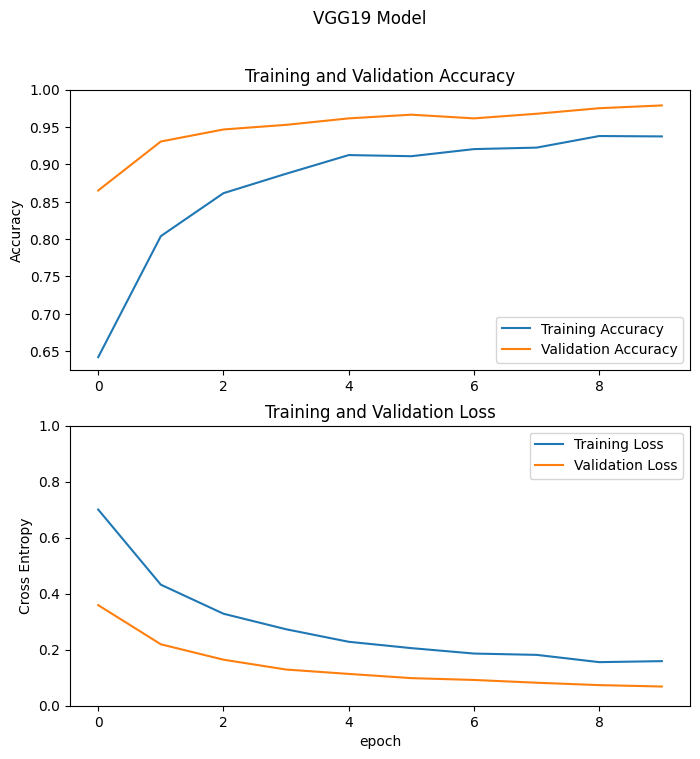

In [75]:
acc_resnet152 = history_resnet152.history['accuracy']
val_acc_resnet152 = history_resnet152.history['val_accuracy']

loss_resnet152 = history_resnet152.history['loss']
val_loss_resnet152 = history_resnet152.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_resnet152, label='Training Accuracy')
plt.plot(val_acc_resnet152, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_resnet152, label='Training Loss')
plt.plot(val_loss_resnet152, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.suptitle("ResNet152 Model")
plt.show()

### Fine Tuning

#### Unfreeze the top layers of the model

In [76]:
base_model_resnet152.trainable = True

In [77]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the ResNet152 base model: ", len(base_model_resnet152.layers))

# Fine-tune from this layer onwards
fine_tune_at_resnet152 = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_resnet152.layers[:fine_tune_at_resnet152]:
  layer.trainable = False

Number of layers in the ResNet152 base model:  515


#### Compile the model

In [78]:
model_resnet152.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [79]:
model_resnet152.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 160, 160,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 160, 160)  │          0 │ sequential[2][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 160, 160)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 160, 160)  │          0 │ sequential[2][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 160, 160,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 160,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet152           │ (None, 5, 5,      │ 58,370,944 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet152[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      2,049 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,372,993 (222.68 MB)

 Trainable params: 23,929,857 (91.29 MB)

 Non-trainable params: 34,443,136 (131.39 MB)

#### Continue training the model

In [80]:
history_fine_resnet152 = model_resnet152.fit(train_dataset, epochs=total_epochs, initial_epoch=len(history.epoch), validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 461ms/step - accuracy: 0.8882 - loss: 0.2731 - val_accuracy: 0.9814 - val_loss: 0.0436
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 352ms/step - accuracy: 0.9501 - loss: 0.1399 - val_accuracy: 0.9839 - val_loss: 0.0386
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - accuracy: 0.9464 - loss: 0.1339 - val_accuracy: 0.9814 - val_loss: 0.0424
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 350ms/step - accuracy: 0.9600 - loss: 0.1069 - val_accuracy: 0.9827 - val_loss: 0.0395
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 357ms/step - accuracy: 0.9694 - loss: 0.0856 - val_accuracy: 0.9802 - val_loss: 0.0421
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 348ms/step - accuracy: 0.9716 - loss: 0.0808 - val_accuracy: 0.9827 - val_loss: 0.0397
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 347ms/step - accuracy: 0.9766 - loss: 0.0694 - val_accuracy: 0.9827 - val_loss: 0.0373
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 0.9843 - loss: 0.0465 - 

In [81]:
acc_resnet152 += history_fine_resnet152.history['accuracy']
val_acc_resnet152 += history_fine_resnet152.history['val_accuracy']

loss_resnet152 += history_fine_resnet152.history['loss']
val_loss_resnet152 += history_fine_resnet152.history['val_loss']

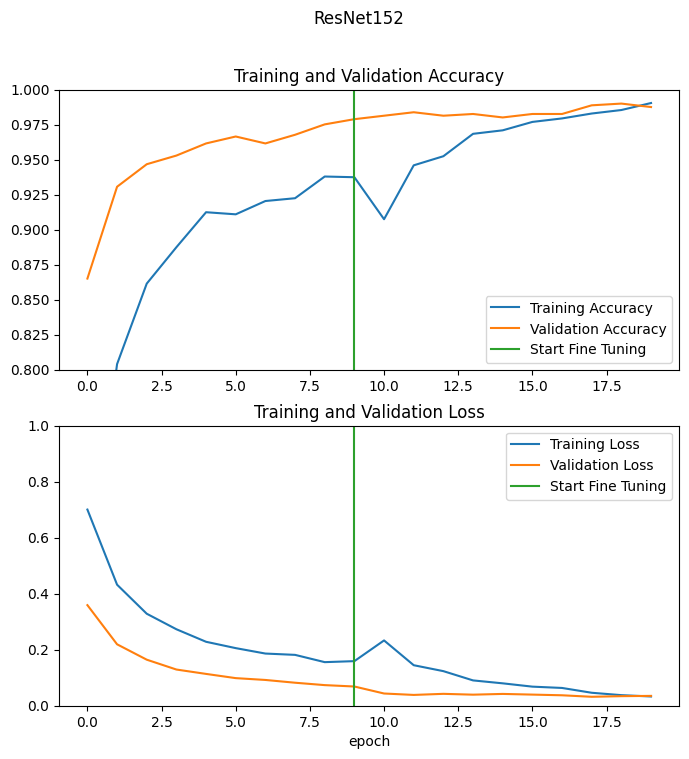

In [82]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_resnet152, label='Training Accuracy')
plt.plot(val_acc_resnet152, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_resnet152, label='Training Loss')
plt.plot(val_loss_resnet152, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.suptitle("ResNet152")
plt.show()

#### Evaluation and prediction

In [84]:
loss_resnet152, accuracy_resnet152 = model_resnet152.evaluate(test_dataset)
print('Test accuracy for ResNet152 model :', accuracy_resnet152)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.9985 - loss: 0.0102
Test accuracy for ResNet152 model : 0.9947916865348816


## Summary


### Summary of Metrics

| Metric               | MobileNetV2 | ResNet101  | ResNet152  |
|:---------------------|------------:|-----------:|-----------:|
| Test Accuracy        | 98.96%      |    98.44%  | 99.48%     |
| Inference Time       | 50 ms/step  | 119ms/step | 175ms/step |
| Finetuning Time      | 1 min       | 4 min      | 7 min      |
| Total params         |   2,259,265 | 42,660,225 | 58,372,993 |
| Trainable params     |   1,862,721 | 21,692,417 | 23,929,857 |
| Non-trainable params |     396,544 | 20,967,808 | 34,443,136 |
| Training Loss        |      0.1012 |     0.0386 |     0.0372 |
| Training Accuracy    |      0.9575 |     0.9886 |     0.9865 |
| Validation Loss      |      0.0359 |     0.0450 |     0.0351 |
| Validation Accuracy  |      0.9864 |     0.9839 |     0.9876 |

### Comparison
- Comparing the size of the models, we see that the MobileNetV2 has a total of 2.2 billion parameters while ResNet101 and ResNet152 have 42.6 billion and 58.3 billion respectively. So, the ResNet models are 20-30 times larger than the baseline MobileNetV2 model.
- Out of these parameters, we have 1.8 billion as trainable in MobileNetV2 whereas in ResNet models we have 21.7 billion and 23.9 billion parameters to train, roughly 10 times more.
- All three models have very similar accuracy, with ResNet152 has a slightly higher accuracy and ResNet101 having a slightly lower accuracy compared to MobileNetv2
  - While the ResNet models are larger, we expect it to perform better than the MobileNet model.
  - However, given that the the finetuning dataset is limited, it could be that we don't have enough training data to properly learn all those parameters.
- MobileNet model has a lesser training time because of simpler model and less number of parametes.
- This also resuls in a lower inference time of the model.
- Based on this, MobileNet gives a balance of speed, size, and performance for this scenario of finetuning with limited dataset, while ResNet152 offers slight accuracy gains at a high computational cost. ResNet models could provide better performance when we have a larger dataset and/or more complex tasks than a binary classification.
